In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

# get training class weight, aff : nff = 2:8
def get_classweight(train_dataset):
    train_nff_count = sum(1 for _, label in train_dataset if label == 0)  # 0 NFF
    train_aff_count = sum(1 for _, label in train_dataset if label == 1)  # 1 AFF
    class_weight_nff = 1 / (2 * (train_nff_count / (train_nff_count + train_aff_count)))
    class_weight_aff = 1 / (2 * (train_aff_count / (train_nff_count + train_aff_count)))
    
    return [class_weight_nff, class_weight_aff] # 0 nff , 1 aff 

# training function
def train_model(train_loader, validation_loader, classweight, num_epochs, lr, step_size, gamma, model_name):
    # Load pre-trained model
    torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')
    
    if model_name == 'resnet18':
        from torchvision.models import resnet18, ResNet18_Weights
        model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    
    elif model_name == 'resnet50':
        from torchvision.models import resnet50, ResNet50_Weights
        model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        
    elif model_name == 'resnet101':
        from torchvision.models import resnet101, ResNet101_Weights
        model = models.resnet101(weights=ResNet101_Weights.DEFAULT)
         
    elif model_name == 'resnet152':
        from torchvision.models import resnet152, ResNet152_Weights
        model = models.resnet152(weights=ResNet152_Weights.DEFAULT)
        
    elif model_name == 'densenet161':
        from torchvision.models import densenet161, DenseNet161_Weights
        model = models.densenet161(weights=DenseNet161_Weights.DEFAULT)

    elif model_name == 'vgg19':
        from torchvision.models import vgg19, VGG19_Weights
        model = models.vgg19(weights=VGG19_Weights.DEFAULT)
        
    else:
        raise ValueError("Invalid model type. 'vgg19' 'resnet50' 'resnet101' 'resnet152' or 'densenet161'.")
    
    # freeze all layers except fc
    # for param in model.parameters():
    #     param.requires_grad = False
    
    # fc
    num_class = 2
    
    if model_name == 'densenet161':
        in_features = model.classifier.in_features
        model.classifier = nn.Sequential(nn.Dropout(0.5),nn.Linear(in_features, num_class)) # dropout
        # model.classifier = nn.Sequential(nn.Linear(in_features, num_class)) # no dropout
    if model_name == 'vgg19':
        in_features = model.classifier[0].in_features
        model.classifier = nn.Sequential(nn.Dropout(0.5),nn.Linear(in_features, num_class)) # dropout
        # model.classifier = nn.Sequential(nn.Linear(in_features, num_class)) # no dropout
    # fc1 = vgg_model.classifier[0]

    else:
        in_features = model.fc.in_features
        model.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(in_features, num_class)) # dropout
        # model.fc = nn.Sequential(nn.Linear(in_features, num_class)) # no dropout
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # # DataParallel speed up
    # if torch.cuda.device_count() > 1:
    #     print("multiple GPU:", torch.cuda.device_count())
    #     model = nn.DataParallel(model)
    # else:
    #     print("single GPU")
    #     model = model.to(device)
    
    # loss function and learning rate
    criterion = nn.CrossEntropyLoss(weight=torch.Tensor(classweight).to(device))
    # optimizer = optim.Adam(model.parameters(), lr=lr)
    
    optimizer = optim.RMSprop(model.parameters(), lr=lr)

    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    # # scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    # scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

        
    # Loss, ACC
    train_losses = []
    validation_losses = []
    train_accuracies = []
    validation_accuracies = []
    
    # select best model
    best_validation_accuracy = 0
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_accuracy = 100 * correct_train / total_train
        
        model.eval()
        correct_validation_aff = 0
        total_validation_aff = 0
        correct_validation = 0
        total_validation = 0
        validation_loss = 0
        
        with torch.no_grad():
            for images, labels in validation_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total_validation += labels.size(0)
                correct_validation += (predicted == labels).sum().item()
                validation_loss += loss.item()
                # Calculate accuracy for AFF class
                total_validation_aff += torch.sum(labels == 1).item()
                correct_validation_aff += torch.sum((predicted == 1) & (labels == 1)).item()

        validation_accuracy_aff = 100 * correct_validation_aff / total_validation_aff

        # validation accuracy and loss
        validation_accuracy = 100 * correct_validation / total_validation
        validation_loss /= len(validation_loader)
        
        train_losses.append(loss.item())
        validation_losses.append(validation_loss)
        train_accuracies.append(train_accuracy)
        validation_accuracies.append(validation_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
            f"train Loss: {loss.item():.4f}, "
            f"val Loss: {validation_loss:.4f}, "
            f"train ACC: {train_accuracy:.2f}%, "
            f"Val ACC: {validation_accuracy:.2f}%")
        
        # scheduler.step()
        scheduler.step()

        # select by high aff ACC
        # if validation_accuracy_aff > best_accuracy:
        #     best_accuracy = validation_accuracy_aff
        #     best_model = model.module if isinstance(model, nn.DataParallel) else model

        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            # best_model = model.module  # DataParallel
            best_model = model  # single device
            
    # Plot train/val loss,  accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(validation_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend() 

    plt.show()

    return best_model

def test_model(model, test_dataset, batch_size):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    model.eval()
    
    correct_test = 0
    total_test = 0
    test_loss = 0
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        all_predictions = []
        all_labels = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            test_loss += loss.item()

    test_accuracy = 100 * correct_test / total_test
    test_loss /= len(test_loader)

    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")
     
    auc_score = roc_auc_score(all_labels, all_predictions)
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    
    # Precision、Recall、F1 Score
    class_labels = {0: 'NFF', 1: 'AFF'}

    classification_rep = classification_report(all_labels, all_predictions, target_names=[class_labels[i] for i in range(len(class_labels))])
    print("AUC:", auc_score)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(classification_rep)

    plot_roc_curve(all_labels, all_predictions)
    
def plot_roc_curve(all_labels, all_predictions):
    fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
    roc_auc = roc_auc_score(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

def show_image(dataset, num_images=5):
    # Get random indices
    random_indices = np.random.choice(len(dataset), num_images, replace=False)

    # Plot images with truncated names
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]  # Use the dataset directly
        filename = dataset.data[idx][0]  # Get the filename from dataset's internal data attribute
        truncated_filename = filename.split('/')[-1][:15]  # Extract the last part and truncate to 15 characters
        
        # Print the original filename
        print(f"Image location: {filename}")

        plt.subplot(1, num_images, i + 1)
        plt.title(f"Label: {label}")
        plt.imshow(image[0])  # Assuming single-channel (grayscale) image
        # plt.imshow(image[0], cmap='gray')  # Assuming single-channel (grayscale) image

        plt.axis('off')
    plt.show()
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = item['image_path']
        label = item['label']

        # Load image
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Convert label to numerical representation
        if label == 'NFF':
            label = 0
        elif label == 'AFF':
            label = 1
        else:
            raise ValueError("Invalid label in JSON data.")

        return image, label

# Define data augmentation transforms for training data
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomAdjustSharpness(sharpness_factor=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load JSON data
with open('/local/data1/honzh073/local_repository/FL/learner_json/hospital43.json', 'r') as json_file:
    json_data = json.load(json_file)
    train_data = json_data['train']
    val_data = json_data['val']

# Create datasets and data loaders
train_dataset = CustomDataset(train_data, transform=train_transform)
val_dataset = CustomDataset(val_data, transform=test_transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# Count 'AFF' and 'NFF' labels in train dataset
train_aff_count = sum(1 for _, label in train_dataset if label == 1)  # 'AFF' label is 1
train_nff_count = sum(1 for _, label in train_dataset if label == 0)  # 'NFF' label is 0

# Count 'AFF' and 'NFF' labels in validation dataset
val_aff_count = sum(1 for _, label in val_dataset if label == 1)  # 'AFF' label is 1
val_nff_count = sum(1 for _, label in val_dataset if label == 0)  # 'NFF' label is 0

print(f"Train dataset: AFF count: {train_aff_count}, NFF count: {train_nff_count}")
print(f"Validation dataset: AFF count: {val_aff_count}, NFF count: {val_nff_count}")
classweight = get_classweight(train_dataset)
print(classweight)

Train dataset: AFF count: 49, NFF count: 123
Validation dataset: AFF count: 26, NFF count: 47
[0.6991869918699186, 1.7551020408163265]


In [13]:
epoch_num = 50
step_size = 10
lr = 1e-4

Epoch 1/50, train Loss: 0.5410, val Loss: 0.6965, train ACC: 55.81%, Val ACC: 63.01%
Epoch 2/50, train Loss: 0.5517, val Loss: 0.7621, train ACC: 60.47%, Val ACC: 63.01%
Epoch 3/50, train Loss: 0.4484, val Loss: 0.5939, train ACC: 69.19%, Val ACC: 60.27%
Epoch 4/50, train Loss: 0.2093, val Loss: 0.4972, train ACC: 69.77%, Val ACC: 65.75%
Epoch 5/50, train Loss: 0.3635, val Loss: 0.5056, train ACC: 81.40%, Val ACC: 78.08%
Epoch 6/50, train Loss: 1.5167, val Loss: 1.4292, train ACC: 88.37%, Val ACC: 71.23%
Epoch 7/50, train Loss: 0.7397, val Loss: 0.9622, train ACC: 90.12%, Val ACC: 73.97%
Epoch 8/50, train Loss: 0.7648, val Loss: 0.7339, train ACC: 90.70%, Val ACC: 73.97%
Epoch 9/50, train Loss: 0.9046, val Loss: 0.9415, train ACC: 88.95%, Val ACC: 73.97%
Epoch 10/50, train Loss: 0.7254, val Loss: 0.7579, train ACC: 90.70%, Val ACC: 78.08%
Epoch 11/50, train Loss: 0.6792, val Loss: 0.7333, train ACC: 93.02%, Val ACC: 79.45%
Epoch 12/50, train Loss: 0.6643, val Loss: 0.7106, train ACC: 9

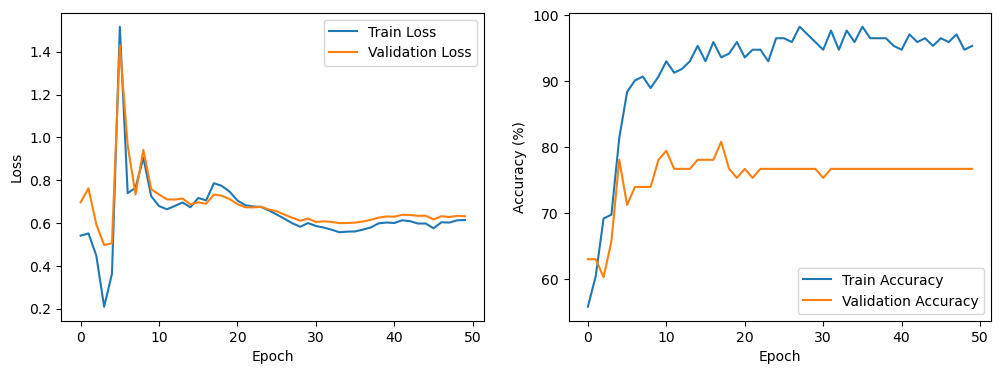

In [14]:
# resnet101
resnet101 = train_model(train_loader, val_loader, classweight, 
                        num_epochs=epoch_num, lr=lr, step_size=step_size, gamma=0.1, model_name='resnet101')


In [ ]:
# save models
resnet101

In [14]:
import csv
import os
from collections import defaultdict

def filter_hospital_data(input_csv_path, target_hospital_ids):
    patient_data = defaultdict(list)

    with open(input_csv_path, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['HospitalID'] in target_hospital_ids:
                patient_id = row['PatientID']
                patient_data[patient_id].append(row)

    hospital_55_data = []
    for images in patient_data.values():
        hospital_55_data.extend(images)

    return hospital_55_data

# Input and output paths
input_csv_path = "/local/data1/honzh073/local_repository/FL/code/3_single_hospital/csv_files/image_data.csv"
output_folder = '/local/data1/honzh073/local_repository/FL/code/3_single_hospital/csv_files/'

# Single hospital id
target_hospital_ids = ['55']

# Get data for hospital 55
hospital_55_data = filter_hospital_data(input_csv_path, target_hospital_ids)

# Write hospital 55 data to CSV file
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=data[0].keys())
        writer.writeheader()
        writer.writerows(data)

# Save hospital 55 data to 'hospital55.csv'
write_to_csv(os.path.join(output_folder, 'hospital55.csv'), hospital_55_data)

print("Saved hospital55.csv for hospital 55.")


Saved hospital55.csv for hospital 55.


ResNet 101
test AFF: 28, ratio: 0.16
---- NFF: 152, ratio: 0.84
Test Loss: 0.3824, Test Acc: 83.33%
AUC: 0.8139097744360901
Confusion Matrix:
[[128  24]
 [  6  22]]
Classification Report:
              precision    recall  f1-score   support

         NFF       0.96      0.84      0.90       152
         AFF       0.48      0.79      0.59        28

    accuracy                           0.83       180
   macro avg       0.72      0.81      0.74       180
weighted avg       0.88      0.83      0.85       180



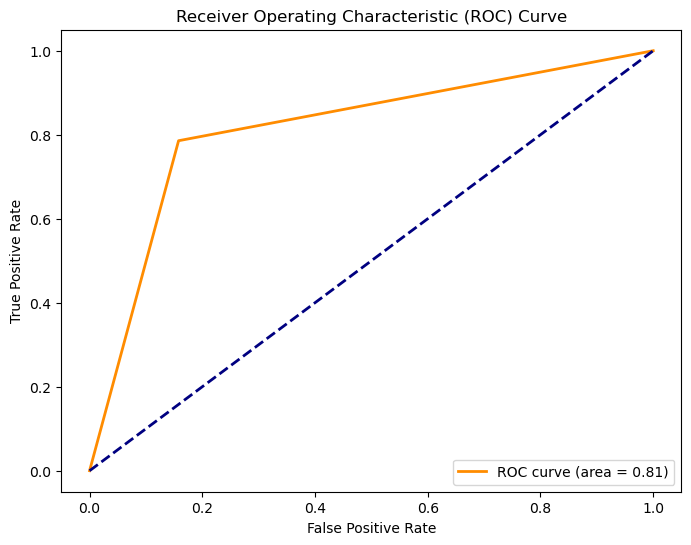

number of parameters: 42504258


In [18]:
print('ResNet 101')
test_dataset = CustomDataset('/local/data1/honzh073/local_repository/FL/code/3_single_hospital/csv_files/hospital55.csv', transform=test_transform)
# For test dataset
test_NFF_count = sum(1 for _, label in test_dataset if label == 0)  # 0 NFF
test_AFF_count = sum(1 for _, label in test_dataset if label == 1)  # 1 AFF
print(f"test AFF: {test_AFF_count}, ratio: {test_AFF_count / (test_AFF_count + test_NFF_count):.2f}")
print(f"---- NFF: {test_NFF_count}, ratio: {test_NFF_count / (test_AFF_count + test_NFF_count):.2f}")

test_model(model=resnet101, test_dataset=test_dataset, batch_size=batch_size)
params_count = count_parameters(resnet101)
print(f"number of parameters: {params_count}")


Epoch 1/50, train Loss: 0.5687, val Loss: 0.6305, train ACC: 54.17%, Val ACC: 68.18%
Epoch 2/50, train Loss: 0.4979, val Loss: 0.5744, train ACC: 65.62%, Val ACC: 74.24%
Epoch 3/50, train Loss: 0.8312, val Loss: 0.7473, train ACC: 66.67%, Val ACC: 63.64%
Epoch 4/50, train Loss: 1.1136, val Loss: 0.9229, train ACC: 76.04%, Val ACC: 39.39%
Epoch 5/50, train Loss: 0.6475, val Loss: 0.6644, train ACC: 71.88%, Val ACC: 75.76%
Epoch 6/50, train Loss: 0.7649, val Loss: 0.7951, train ACC: 84.38%, Val ACC: 57.58%
Epoch 7/50, train Loss: 0.2396, val Loss: 0.5262, train ACC: 87.50%, Val ACC: 65.15%
Epoch 8/50, train Loss: 0.5222, val Loss: 0.6728, train ACC: 94.79%, Val ACC: 62.12%
Epoch 9/50, train Loss: 0.0058, val Loss: 0.3999, train ACC: 92.71%, Val ACC: 74.24%
Epoch 10/50, train Loss: 0.0006, val Loss: 0.4200, train ACC: 96.88%, Val ACC: 75.76%
Epoch 11/50, train Loss: 0.0013, val Loss: 0.3907, train ACC: 97.92%, Val ACC: 74.24%
Epoch 12/50, train Loss: 0.0052, val Loss: 0.3758, train ACC: 9

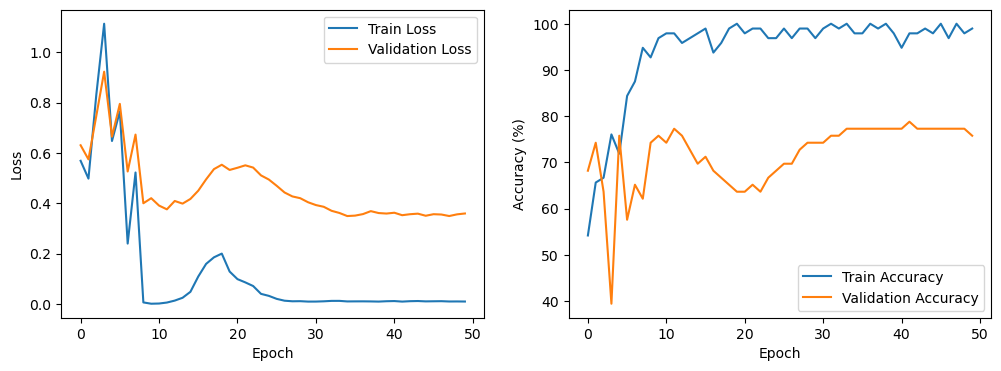

In [420]:
# resnet152
resnet152 = train_model(train_loader, val_loader, classweight, 
                        num_epochs=epoch_num, lr=lr, step_size=step_size, gamma=0.1, model_name='resnet152')


ResNet 152
Test Loss: 0.3846, Test Acc: 79.52%
AUC: 0.8181159420289854
Confusion Matrix:
[[46 14]
 [ 3 20]]
Classification Report:
              precision    recall  f1-score   support

         NFF       0.94      0.77      0.84        60
         AFF       0.59      0.87      0.70        23

    accuracy                           0.80        83
   macro avg       0.76      0.82      0.77        83
weighted avg       0.84      0.80      0.80        83



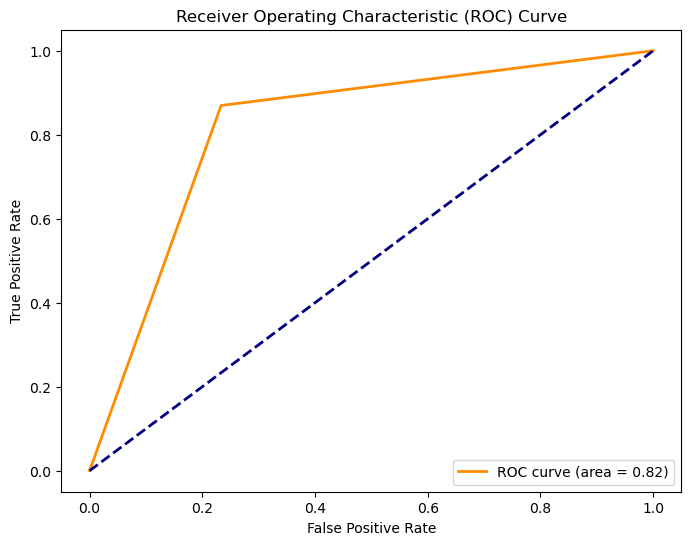

number of parameters: 58147906


In [421]:
print('ResNet 152')

test_model(model=resnet152, test_dataset=test_dataset, batch_size=batch_size)
params_count = count_parameters(resnet152)
print(f"number of parameters: {params_count}")


In [422]:
# densenet161

# densenet161 = train_model(train_loader, val_loader, classweight, 
#                           num_epochs=epoch_num, lr=lr, step_size=step_size, gamma=0.1, model_name='densenet161')


In [423]:
# test_model(model=densenet161, test_dataset=test_dataset, batch_size=batch_size)

In [424]:
# # vgg19
# vgg19 = train_model(train_loader, val_loader, classweight, 
#                           num_epochs=epoch_num, lr=lr, step_size=step_size, gamma=0.1, model_name='vgg19')


In [425]:
# test_model(model=vgg19, test_dataset=test_dataset, batch_size=batch_size)